In [2]:

!unzip Synthetic_Dataset.zip

Archive:  Synthetic_Dataset.zip
  inflating: Synthetic_Dataset/MIA_screen_10/164314_050.jpg  
  inflating: Synthetic_Dataset/MIA_screen_10/164314_060.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164325_024.jpg  
  inflating: Synthetic_Dataset/MIA_screen_10/164314_010.jpg  
  inflating: Synthetic_Dataset/paper_40/181449_24.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_088.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_086.jpg  
  inflating: Synthetic_Dataset/paper_40/181448_45.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_085.jpg  
  inflating: Synthetic_Dataset/MIA_screen_10/164314_021.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_087.jpg  
  inflating: Synthetic_Dataset/paper_40/169839_015.jpg  
  inflating: Synthetic_Dataset/paper_40/181448_56.jpg  
  inflating: Synthetic_Dataset/MIA_screen_10/164314_005.jpg  
  inflating: Synthetic_Dataset/MIA_paper_10/164317_080.jpg  
  inflating: Synthetic_Dataset/paper_40/181465_24.jpg  
  inflating

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!pip install opacus


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 19.8 MB/s eta 0:00:00


# Load the dataset

Loading 40 images from paper_40 with label 'paper'
Loading 40 images from screen_40 with label 'screen'
Loading 40 images from wander_40 with label 'wander'
Total images loaded: 120
Label distribution: {np.str_('paper'): np.int64(40), np.str_('screen'): np.int64(40), np.str_('wander'): np.int64(40)}

Displaying sample images from the dataset:


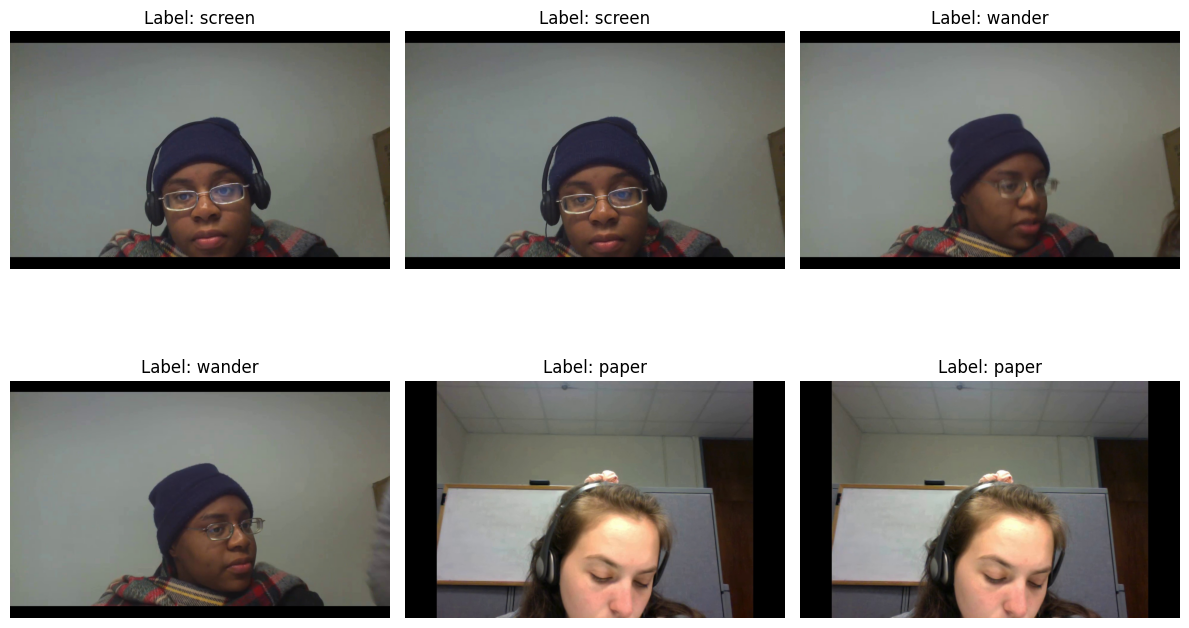

In [4]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def load_synthetic_dataset(dataset_path):
    images = []
    labels = []

    # Define the subdirectories and their corresponding labels
    subdirs_labels = {
        'paper_40': 'paper',
        'screen_40': 'screen',
        'wander_40': 'wander'
    }

    for subdir, label in subdirs_labels.items():
        subdir_path = os.path.join(dataset_path, subdir)

        if not os.path.exists(subdir_path):
            print(f"Warning: Directory {subdir_path} does not exist")
            continue

        # Get all jpg files in the subdirectory
        image_files = [f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')]

        print(f"Loading {len(image_files)} images from {subdir} with label '{label}'")

        for image_file in sorted(image_files):
            image_path = os.path.join(subdir_path, image_file)

            try:
                # Load image using OpenCV
                image = cv2.imread(image_path)
                if image is not None:
                    # Convert from BGR to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                    labels.append(label)
                else:
                    print(f"Warning: Could not load image {image_path}")
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    print(f"Total images loaded: {len(images)}")
    print(f"Label distribution: {dict(zip(*np.unique(labels, return_counts=True)))}")

    return images, labels

# Load the synthetic dataset
dataset_path = "Synthetic_Dataset"
images, labels = load_synthetic_dataset(dataset_path)

# Display some sample images
def display_sample_images(images, labels, num_samples=6):
    """Display sample images from the dataset"""
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    # Get unique labels and their indices
    unique_labels = list(set(labels))
    samples_per_label = num_samples // len(unique_labels)

    sample_indices = []
    for label in unique_labels:
        label_indices = [i for i, l in enumerate(labels) if l == label]
        sample_indices.extend(label_indices[:samples_per_label])

    for i, idx in enumerate(sample_indices[:num_samples]):
        axes[i].imshow(images[idx])
        axes[i].set_title(f"Label: {labels[idx]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
print("\nDisplaying sample images from the dataset:")
display_sample_images(images, labels)

# Load the dataset for resnet training

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert numpy array to PIL Image for transforms
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

# Encode string labels to integers
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print(f'Label mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}')

# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')

# Create datasets
train_dataset = ImageDataset(X_train, y_train, transform=train_transform)
val_dataset = ImageDataset(X_val, y_val, transform=val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f'Number of training batches: {len(train_loader)}')
print(f'Number of validation batches: {len(val_loader)}')

# Load ResNet18 model
num_classes = len(label_encoder.classes_)
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

print(f'ResNet18 model loaded with {num_classes} output classes')
print(f'Model architecture:')
print(model)

Label mapping: {np.str_('paper'): 0, np.str_('screen'): 1, np.str_('wander'): 2}
Training set size: 96
Validation set size: 24
Number of training batches: 3
Number of validation batches: 1


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 91.9MB/s]


ResNet18 model loaded with 3 output classes
Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

# Train and evaluate the model

Using device: cuda
Starting DP-SGD Grid Search...
Grid: Clip norms = [0.5, 1.0], Noise multipliers = [0.5, 1.0, 2.0]
Epochs = 20, Batch size = 64, Delta = 0.01


######################################################################
Grid Search: C=0.5, σ=0.5
######################################################################


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18 model loaded with 3 output classes
Model architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


Epoch [1/20], Batch [0/3], Loss: 1.0856
Epoch [1/20] - Train Loss: 2.1999, Train Acc: 40.19%, Val Loss: 1.1159, Val Acc: 33.33%, ε: 6.66
Epoch [2/20], Batch [0/3], Loss: 1.1242
Epoch [2/20] - Train Loss: 1.8547, Train Acc: 35.64%, Val Loss: 1.1583, Val Acc: 33.33%, ε: 9.72
Epoch [3/20], Batch [0/3], Loss: 1.1849
Epoch [3/20] - Train Loss: 1.4807, Train Acc: 37.89%, Val Loss: 1.1711, Val Acc: 33.33%, ε: 12.31
Epoch [4/20], Batch [0/3], Loss: 1.1469
Epoch [4/20] - Train Loss: 1.2007, Train Acc: 31.03%, Val Loss: 1.1330, Val Acc: 33.33%, ε: 14.67
Epoch [5/20], Batch [0/3], Loss: 1.0656
Epoch [5/20] - Train Loss: 1.0947, Train Acc: 35.48%, Val Loss: 1.0802, Val Acc: 33.33%, ε: 16.87
Epoch [6/20], Batch [0/3], Loss: 1.0682
Epoch [6/20] - Train Loss: 1.0664, Train Acc: 43.53%, Val Loss: 1.0750, Val Acc: 33.33%, ε: 18.97
Epoch [7/20], Batch [0/3], Loss: 1.0450
Epoch [7/20] - Train Loss: 1.4594, Train Acc: 33.70%, Val Loss: 1.0975, Val Acc: 33.33%, ε: 20.98
Epoch [8/20], Batch [0/3], Loss: 1.0

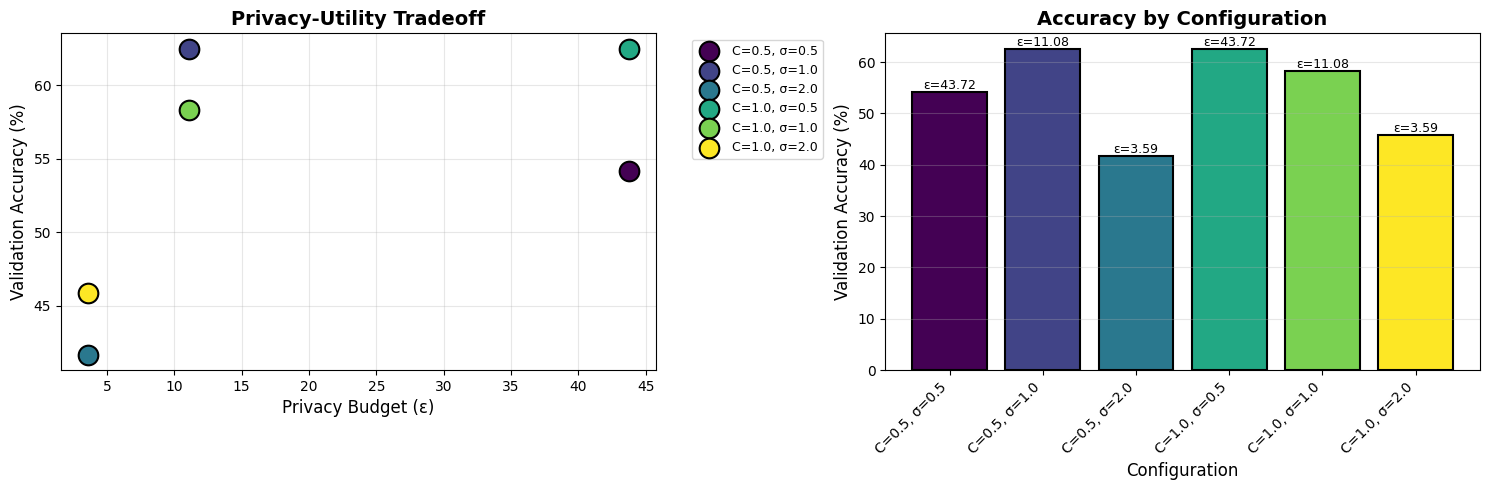

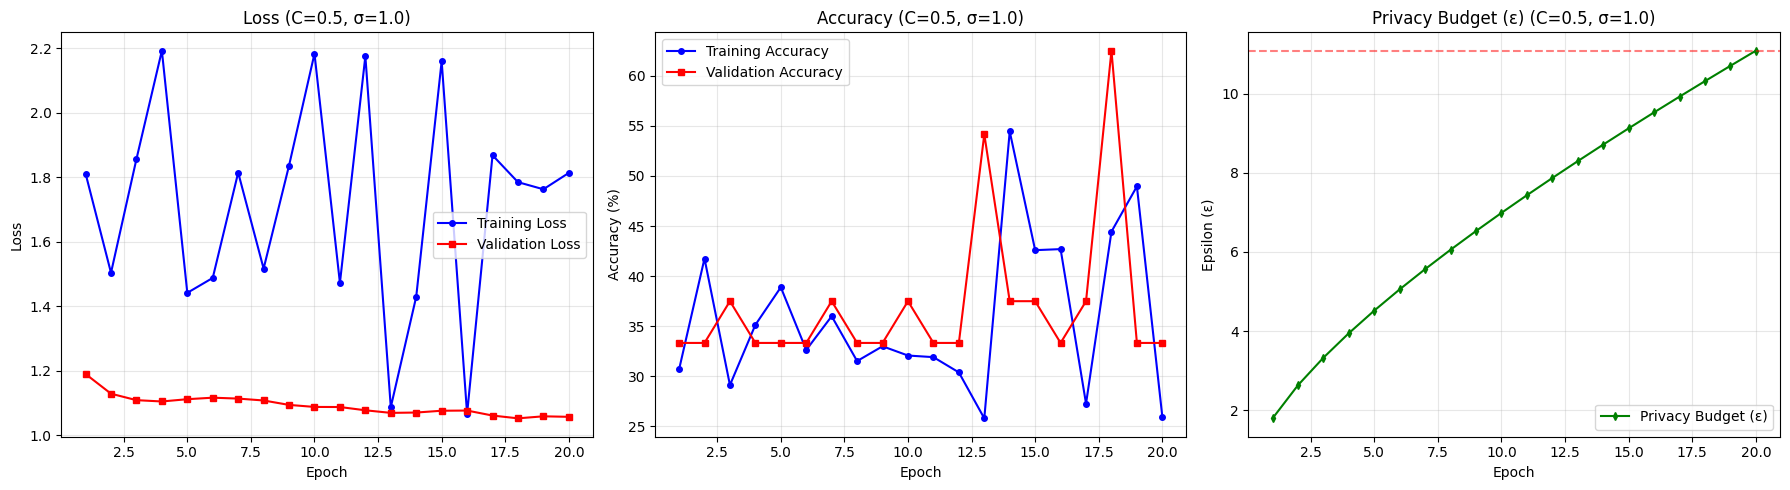

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
from opacus.validators import ModuleValidator

def basicblock_forward(self, x):
    """Forward pass for ResNet BasicBlock without in-place operations."""
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    # Use clone to avoid in-place modification
    out = out.clone() + identity
    out = self.relu(out)

    return out

def bottleneck_forward(self, x):
    """Forward pass for ResNet Bottleneck without in-place operations."""
    identity = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)

    if self.downsample is not None:
        identity = self.downsample(x)

    # Use clone to avoid in-place modification
    out = out.clone() + identity
    out = self.relu(out)

    return out

def make_model_dp_compatible(model):
    """
    Make a model compatible with Opacus by fixing in-place operations.
    Handles both ReLU and residual connections in ResNet.
    """
    # Step 1: Replace all in-place ReLU
    for module in model.modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False

    # Step 2: Fix residual blocks - replace forward method
    for module in model.modules():
        classname = module.__class__.__name__

        # For ResNet BasicBlock
        if classname == 'BasicBlock':
            bound_method = basicblock_forward.__get__(module, module.__class__)
            setattr(module, 'forward', bound_method)

        # For ResNet Bottleneck
        elif classname == 'Bottleneck':
            bound_method = bottleneck_forward.__get__(module, module.__class__)
            setattr(module, 'forward', bound_method)

    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ============================================================================
# DP-SGD Configuration
# ============================================================================
# Grid search parameters
CLIP_NORMS = [0.5, 1.0]
#CLIP_NORMS = [0.5]
#NOISE_MULTIPLIERS = [0.5]
NOISE_MULTIPLIERS = [0.5, 1.0, 2.0]

# Training parameters (adjusted for DP-SGD)
NUM_EPOCHS = 20
BATCH_SIZE = 64  # Reasonable batch size for DP-SGD
MAX_PHYSICAL_BATCH_SIZE = 32  # For memory efficiency with Opacus

DELTA = 1e-2

# ============================================================================
# DP-SGD Training Function
# ============================================================================
def train_model_dp(model, train_loader, val_loader, criterion,
                   clip_norm, noise_multiplier, num_epochs=NUM_EPOCHS):
    """
    Train model with Differential Privacy using Opacus.

    Args:
        model: PyTorch model
        train_loader: Training data loader
        val_loader: Validation data loader
        criterion: Loss function
        clip_norm: Maximum gradient norm (C)
        noise_multiplier: Noise multiplier (σ)
        num_epochs: Number of training epochs

    Returns:
        Tuple of (model, metrics, epsilon)
    """
    model = model.to(device)

    model = ModuleValidator.fix(model)
    ModuleValidator.validate(model, strict=False)
    model = make_model_dp_compatible(model)

    # Initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    # Initialize Privacy Engine and make model private
    privacy_engine = PrivacyEngine()

    model, optimizer, train_loader = privacy_engine.make_private(
         module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=noise_multiplier,
        max_grad_norm=clip_norm,
    )

    print(f"\n{'='*70}")
    print(f"Training with DP-SGD: C={clip_norm}, σ={noise_multiplier}")
    print(f"Target δ={DELTA}")
    print(f"{'='*70}\n")

    # Training metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    epsilon_per_epoch = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # Use BatchMemoryManager for efficient memory usage
        with BatchMemoryManager(
            data_loader=train_loader,
            max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE,
            optimizer=optimizer
        ) as memory_safe_data_loader:

            for batch_idx, (data, target) in enumerate(memory_safe_data_loader):
                data, target = data.to(device), target.to(device)

                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += target.size(0)
                correct_train += (predicted == target).sum().item()

                if batch_idx % 10 == 0:
                    print(f'Epoch [{epoch+1}/{num_epochs}], '
                          f'Batch [{batch_idx}/{len(train_loader)}], '
                          f'Loss: {loss.item():.4f}')

        # Calculate training metrics
        train_acc = 100 * correct_train / total_train
        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        val_acc = 100 * correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)

        # Compute privacy budget (epsilon)
        epsilon = privacy_engine.get_epsilon(DELTA)
        epsilon_per_epoch.append(epsilon)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
              f'ε: {epsilon:.2f}')

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    final_epsilon = privacy_engine.get_epsilon(DELTA)

    print(f"\n{'='*70}")
    print(f"Training Complete!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f"Final Privacy Budget: ε={final_epsilon:.2f} at δ={DELTA}")
    print(f"{'='*70}\n")

    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'epsilon_per_epoch': epsilon_per_epoch,
        'best_val_acc': best_val_acc,
        'clip_norm': clip_norm,
        'noise_multiplier': noise_multiplier
    }
    del model
    return metrics, final_epsilon

# ============================================================================
# Grid Search for DP Hyperparameters
# ============================================================================
def dp_grid_search(train_loader, val_loader):
    """
    Perform grid search over clip norms and noise multipliers.

    Returns:
        Dictionary with results for each configuration
    """
    results = []
    criterion = nn.CrossEntropyLoss()

    for clip_norm in CLIP_NORMS:
        for noise_multiplier in NOISE_MULTIPLIERS:
            print(f"\n{'#'*70}")
            print(f"Grid Search: C={clip_norm}, σ={noise_multiplier}")
            print(f"{'#'*70}")

            # Create fresh model instance
            num_classes = len(label_encoder.classes_)
            model = models.resnet18(pretrained=True)
            model.fc = nn.Linear(model.fc.in_features, num_classes)

            print(f'ResNet18 model loaded with {num_classes} output classes')
            print(f'Model architecture:')
            print(model)

            # Train with DP-SGD
            import time
            start_time = time.time()

            metrics, final_epsilon = train_model_dp(
                model, train_loader, val_loader, criterion,
                clip_norm, noise_multiplier, NUM_EPOCHS
            )

            training_time = time.time() - start_time

            results.append({
                'clip_norm': clip_norm,
                'noise_multiplier': noise_multiplier,
                'epsilon': final_epsilon,
                'delta': DELTA,
                'best_val_acc': metrics['best_val_acc'],
                'training_time': training_time,
                'metrics': metrics
            })

            print(f"Training completed in {training_time:.2f} seconds\n")

    return results

# ============================================================================
# Visualization Functions
# ============================================================================
def plot_training_progress(metrics, title_suffix=""):
    """Plot training and validation metrics."""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    epochs = range(1, len(metrics['train_losses']) + 1)

    # Plot losses
    ax1.plot(epochs, metrics['train_losses'], label='Training Loss',
             color='blue', marker='o', markersize=4)
    ax1.plot(epochs, metrics['val_losses'], label='Validation Loss',
             color='red', marker='s', markersize=4)
    ax1.set_title(f'Loss {title_suffix}')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies
    ax2.plot(epochs, metrics['train_accuracies'], label='Training Accuracy',
             color='blue', marker='o', markersize=4)
    ax2.plot(epochs, metrics['val_accuracies'], label='Validation Accuracy',
             color='red', marker='s', markersize=4)
    ax2.set_title(f'Accuracy {title_suffix}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot epsilon over time
    ax3.plot(epochs, metrics['epsilon_per_epoch'], label='Privacy Budget (ε)',
             color='green', marker='d', markersize=4)
    ax3.set_title(f'Privacy Budget (ε) {title_suffix}')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Epsilon (ε)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=metrics['epsilon_per_epoch'][-1], color='r',
                linestyle='--', alpha=0.5, label=f'Final ε={metrics["epsilon_per_epoch"][-1]:.2f}')

    plt.tight_layout()
    plt.show()

def plot_grid_search_results(results):
    """Visualize grid search results."""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Extract data for plotting
    clip_norms = [r['clip_norm'] for r in results]
    noise_mults = [r['noise_multiplier'] for r in results]
    epsilons = [r['epsilon'] for r in results]
    accuracies = [r['best_val_acc'] for r in results]

    # Create labels
    labels = [f"C={c}, σ={s}" for c, s in zip(clip_norms, noise_mults)]

    # Plot 1: Epsilon vs Accuracy
    colors = plt.cm.viridis(np.linspace(0, 1, len(results)))
    for i, (eps, acc, label) in enumerate(zip(epsilons, accuracies, labels)):
        axes[0].scatter(eps, acc, s=200, c=[colors[i]], label=label,
                       edgecolors='black', linewidth=1.5)

    axes[0].set_xlabel('Privacy Budget (ε)', fontsize=12)
    axes[0].set_ylabel('Validation Accuracy (%)', fontsize=12)
    axes[0].set_title('Privacy-Utility Tradeoff', fontsize=14, fontweight='bold')
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Bar chart of accuracies
    x_pos = np.arange(len(results))
    bars = axes[1].bar(x_pos, accuracies, color=colors, edgecolor='black', linewidth=1.5)
    axes[1].set_xlabel('Configuration', fontsize=12)
    axes[1].set_ylabel('Validation Accuracy (%)', fontsize=12)
    axes[1].set_title('Accuracy by Configuration', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(labels, rotation=45, ha='right')
    axes[1].grid(True, alpha=0.3, axis='y')

    # Add epsilon values on bars
    for i, (bar, eps) in enumerate(zip(bars, epsilons)):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'ε={eps:.2f}',
                    ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def print_results_summary(results):
    """Print formatted summary of all results."""
    print("\n" + "="*80)
    print(" "*20 + "DP-SGD GRID SEARCH RESULTS SUMMARY")
    print("="*80)
    print(f"{'Config':<15} {'Clip (C)':<12} {'Noise (σ)':<12} {'Epsilon (ε)':<15} "
          f"{'Accuracy (%)':<15} {'Time (s)':<10}")
    print("-"*80)

    for i, r in enumerate(results):
        print(f"Config {i+1:<7} {r['clip_norm']:<12.1f} {r['noise_multiplier']:<12.1f} "
              f"{r['epsilon']:<15.2f} {r['best_val_acc']:<15.2f} {r['training_time']:<10.1f}")

    print("="*80)

    # Find best configurations
    best_acc_idx = np.argmax([r['best_val_acc'] for r in results])
    best_privacy_idx = np.argmin([r['epsilon'] for r in results])

    print("\nBest Accuracy Configuration:")
    print(f"  C={results[best_acc_idx]['clip_norm']}, "
          f"σ={results[best_acc_idx]['noise_multiplier']}, "
          f"ε={results[best_acc_idx]['epsilon']:.2f}, "
          f"Accuracy={results[best_acc_idx]['best_val_acc']:.2f}%")

    print("\nBest Privacy Configuration (lowest ε):")
    print(f"  C={results[best_privacy_idx]['clip_norm']}, "
          f"σ={results[best_privacy_idx]['noise_multiplier']}, "
          f"ε={results[best_privacy_idx]['epsilon']:.2f}, "
          f"Accuracy={results[best_privacy_idx]['best_val_acc']:.2f}%")
    print("="*80 + "\n")

# ============================================================================
# Evaluation Functions
# ============================================================================
def evaluate_model(model, val_loader, label_encoder):
    """Evaluate model and generate detailed metrics."""
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * sum(p == t for p, t in zip(all_predictions, all_targets)) / len(all_targets)
    print(f'Final Validation Accuracy: {accuracy:.2f}%')

    # Classification report
    class_names = label_encoder.classes_
    print('\nClassification Report:')
    print(classification_report(all_targets, all_predictions, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.tight_layout()
    plt.show()

    return accuracy, all_predictions, all_targets

def test_sample_predictions(model, val_dataset, label_encoder, num_samples=6):
    """Display sample predictions."""
    model.eval()
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    indices = np.random.choice(len(val_dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = val_dataset[idx]
            image_batch = image.unsqueeze(0).to(device)

            output = model(image_batch)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

            # Convert back to original image for display
            image_display = image.permute(1, 2, 0).cpu().numpy()
            # Denormalize for display
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_display = std * image_display + mean
            image_display = np.clip(image_display, 0, 1)

            axes[i].imshow(image_display)
            true_class = label_encoder.inverse_transform([true_label])[0]
            pred_class = label_encoder.inverse_transform([predicted_label])[0]
            axes[i].set_title(f'True: {true_class}\nPred: {pred_class}',
                            color='green' if true_class == pred_class else 'red',
                            fontsize=11, fontweight='bold')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# ============================================================================
# Main Execution
# ============================================================================
# Run grid search
# Assumes you have: model (your ResNet18 or similar), train_loader, val_loader, label_encoder
print("Starting DP-SGD Grid Search...")
print(f"Grid: Clip norms = {CLIP_NORMS}, Noise multipliers = {NOISE_MULTIPLIERS}")
print(f"Epochs = {NUM_EPOCHS}, Batch size = {BATCH_SIZE}, Delta = {DELTA}\n")

results = dp_grid_search(train_loader, val_loader)
print_results_summary(results)
plot_grid_search_results(results)

# Evaluate best model:
best_idx = np.argmax([r['best_val_acc'] for r in results])
#best_model = results[best_idx]['model']
best_metrics = results[best_idx]['metrics']

plot_training_progress(best_metrics,
                       f"(C={best_metrics['clip_norm']}, σ={best_metrics['noise_multiplier']})")
#evaluate_model(best_model, val_loader, label_encoder)
# test_sample_predictions(best_model, val_dataset, label_encoder)